In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

class RainPredictor:
    def __init__(self, path):
        self._df = pd.read_csv(path, delimiter=",")
        self._target_col = 'y'
        self._features = self._select_features()
        self._scaler = StandardScaler()
        self._classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    def _select_features(self, corr_threshold=0.1):
        numeric_df = self._df.select_dtypes(include=[np.number])
        corr = numeric_df.corr()[self._target_col].drop(self._target_col)
        corr = corr[abs(corr) > corr_threshold].index.tolist()
        if 'mesic' not in corr:
            corr.append('mesic')
        print(f"Regressors: {corr}")
        print(f"Target: {self._target_col}")
        return corr

    def _prepare_feature_matrix(self):
        data = self._df[self._features]
        df_shifted = pd.concat(
            [data.shift(i) for i in range(7, 0, -1)],
            axis=1,
            keys=[f"n_{i}" for i in range(7, 0, -1)]
        )
        df_shifted.columns = [f"{prefix}_{col}" for prefix, col in df_shifted.columns]
        df_shifted[self._target_col] = self._df[self._target_col].shift(-1)
        df_shifted.dropna(inplace=True)
        X = df_shifted.drop(columns=[self._target_col])
        y = df_shifted[self._target_col].astype(int)
        return X, y

    def _build_features(self):
        df = self._df.copy()
        features = self._features
        target = self._target_col
        all_feature_names = []
        trend_df = pd.DataFrame()
        for col in features:
            trend_df[f'{col}_last'] = df[col].shift(1)
            trend_df[f'{col}_mean3'] = df[col].shift(1).rolling(window=3).mean()
            trend_df[f'{col}_delta'] = df[col].shift(1) - df[col].shift(2)
            all_feature_names.extend([f'{col}_last', f'{col}_mean3', f'{col}_delta'])
        trend_df[target] = df[target].shift(-1)
        trend_df.dropna(inplace=True)
        X = trend_df[all_feature_names]
        y = trend_df[target].astype(int)
        X_scaled = self._scaler.fit_transform(X)
        return train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    def train(self, threshold=0.4):
        X_train, X_test, y_train, y_test = self._build_features()
        self._classifier.fit(X_train, y_train)
        y_proba = self._classifier.predict_proba(X_test)[:, 1]
        y_pred = (y_proba > threshold).astype(int)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n✅ Celková přesnost modelu (threshold={threshold}): {acc:.2%}\n")
        return pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

    def correlation_matrix(self):
        numeric_df = self._df.select_dtypes(include=[np.number])
        corr = numeric_df.corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title("Korelační matice")
        plt.tight_layout()
        plt.show()
        return corr

    def plot_confusion_matrix(self):
        X_train, X_test, y_train, y_test = self._build_features()
        self._classifier.fit(X_train, y_train)
        y_pred = self._classifier.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(9.4, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Neprší", "Prší"], yticklabels=["Neprší", "Prší"])
        plt.xlabel("Predikce")
        plt.ylabel("Skutečnost")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
        return cm

    def evaluate_thresholds(self, thresholds=np.arange(0.25, 0.76, 0.05)):
        from sklearn.metrics import precision_score, recall_score, f1_score
        X_train, X_test, y_train, y_test = self._build_features()
        self._classifier.fit(X_train, y_train)
        y_proba = self._classifier.predict_proba(X_test)[:, 1]
        results = []
        for t in thresholds:
            y_pred = (y_proba > t).astype(int)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, pos_label=1)
            recall = recall_score(y_test, y_pred, pos_label=1)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            results.append({
                'threshold': round(t, 2),
                'accuracy': round(acc, 3),
                'precision_1': round(precision, 3),
                'recall_1': round(recall, 3),
                'f1_1': round(f1, 3)
            })
        df = pd.DataFrame(results)
        return df


Regressors: ['max_naraz_vitr', 'vlhkost', 'uhrn_srazky', 'tlak', 'mesic']
Target: y

✅ Celková přesnost modelu (threshold=0.4): 56.83%

              precision    recall  f1-score     support
0              0.701923  0.521429  0.598361  140.000000
1              0.455285  0.643678  0.533333   87.000000
accuracy       0.568282  0.568282  0.568282    0.568282
macro avg      0.578604  0.582553  0.565847  227.000000
weighted avg   0.607396  0.568282  0.573438  227.000000


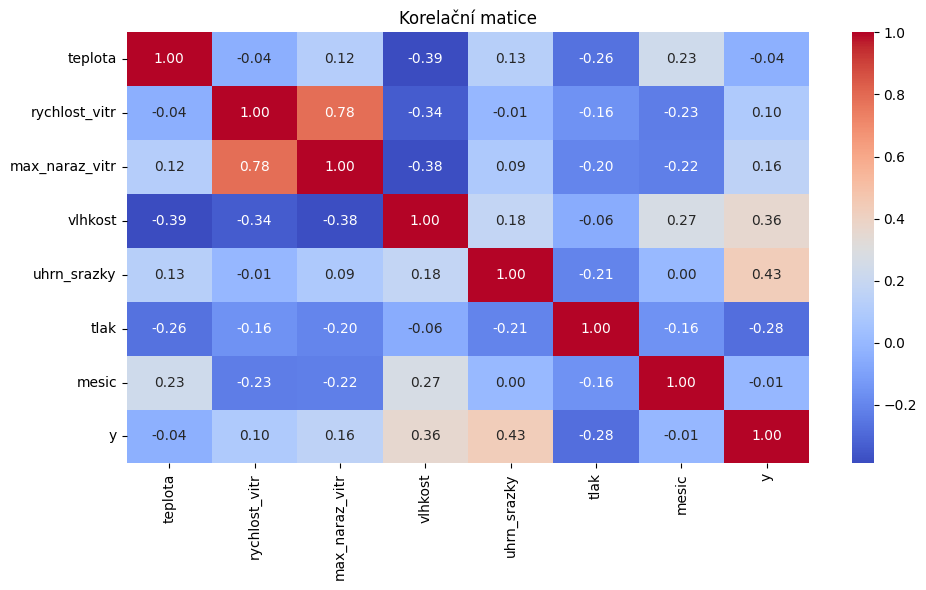

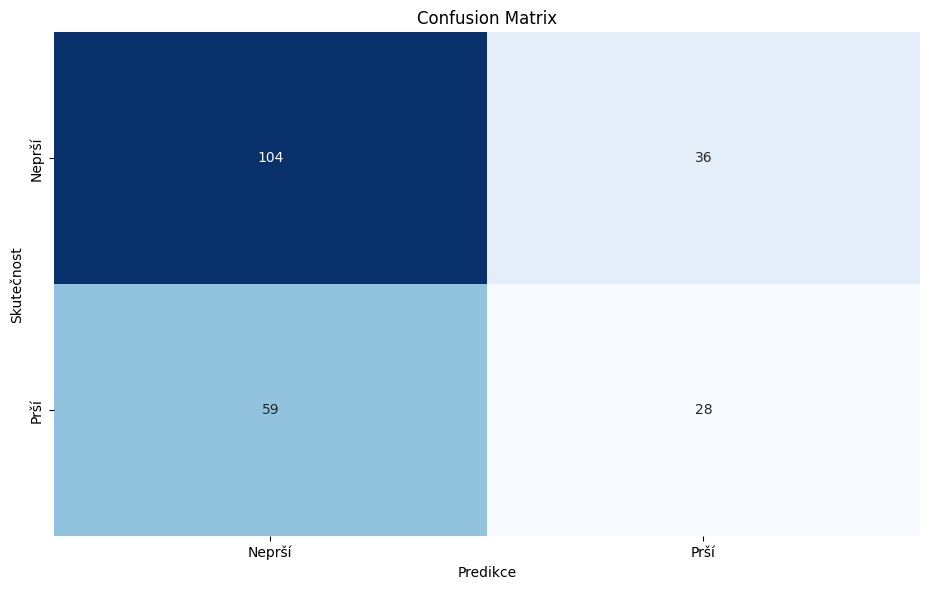

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,accuracy,precision_1,recall_1,f1_1
0,0.25,0.480,0.418,0.908,0.572
1,0.30,0.507,0.428,0.851,0.569
2,0.35,0.537,0.440,0.759,0.557
3,0.40,0.546,0.438,0.655,0.525
4,0.45,0.559,0.436,0.506,0.468
5,0.50,0.586,0.448,0.345,0.390
6,0.55,0.590,0.425,0.195,0.268
7,0.60,0.581,0.346,0.103,0.159
8,0.65,0.586,0.231,0.034,0.060
9,0.70,0.608,0.000,0.000,0.000


In [173]:
predictor = RainPredictor("pocasi.csv")
print(predictor.train())
predictor.correlation_matrix()
predictor.plot_confusion_matrix()
predictor.evaluate_thresholds()

In [182]:
import pandas as pd
import numpy as np

In [183]:
df = pd.read_csv('kopisty_pocasi_rozsireno.csv', decimal=",", delimiter=";", parse_dates=True)
df['datum'] = pd.to_datetime(df['datum'], format='%d.%m.%Y')
df.dropna()
df.head()
df.drop(columns="vypar", inplace=True)
df.head()

,datum,teplota,uhrn_srazky_1,rychlost_vitr,max_naraz_vitr,vlhkost,uhrn_srazky_2,tlak
0,2019-09-01,19.2,20.1,0.6,10.8,94,12.6,1007.116499
1,2019-09-02,15.1,0.0,2.0,11.4,64,0.0,1016.544746
2,2019-09-03,15.3,0.0,0.8,6.4,70,0.0,1019.923534
3,2019-09-04,17.0,0.0,0.9,8.0,70,0.0,1013.585624
4,2019-09-05,15.8,0.0,1.9,11.4,67,0.0,1013.116874


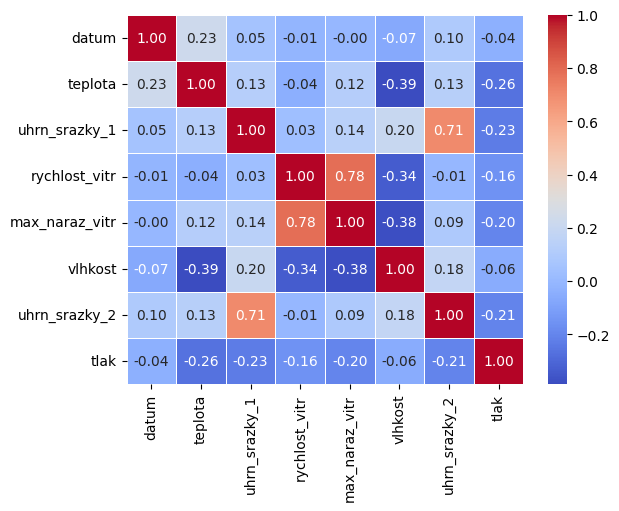

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [185]:
# extrakce pozadovanych sloupcu
data = pd.DataFrame()
data["dest"]=(df["uhrn_srazky_1"]+df["uhrn_srazky_2"])/2
data["teplota"]=df['teplota']
data["vitr"]=df["rychlost_vitr"]
data["vlhkost"] = df['vlhkost']
data["tlak"]=df["tlak"]
data["obdobi"]=df['datum'].dt.month

In [186]:
# metoda pro generovani datasetu
def transform(data, k_predem):
  X=[]
  y=[]
  for row in range(k_predem, len(data)-1):
     X.append(data[row-k_predem:row].to_numpy().flatten())
     y.append(int(data.iloc[row+1]["dest"]>0))

  return np.array(X), y

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier

X,y = transform(data, 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

classifier =  RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_hat_train = classifier.predict(X_train)
print(classification_report(y_train, y_hat_train))

y_hat_test = classifier.predict(X_test)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       304

    accuracy                           1.00       607
   macro avg       1.00      1.00      1.00       607
weighted avg       1.00      1.00      1.00       607

              precision    recall  f1-score   support

           0       0.61      0.55      0.58        80
           1       0.55      0.61      0.58        72

    accuracy                           0.58       152
   macro avg       0.58      0.58      0.58       152
weighted avg       0.58      0.58      0.58       152

